<a href="https://colab.research.google.com/github/kangnurrohman/belajar-recurrent-neural-network/blob/main/materi/Part%207%20-%20Bidirectional%20with%20PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install jcopdl luwiji

In [3]:
import zipfile
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Colab Notebooks/data/data 4.zip", 'r')
zip_ref.extractall("data")
zip_ref.close()

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [5]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Import Data

In [6]:
df = pd.read_csv("/content/data/daily_min_temp.csv", index_col="Date", parse_dates=["Date"])
df.head()

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


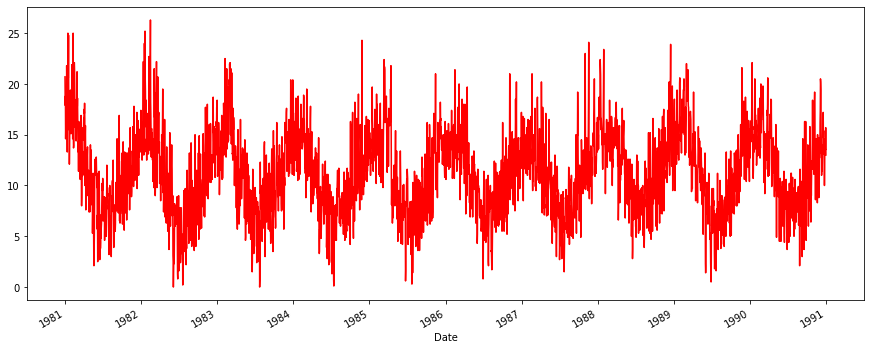

In [7]:
df.Temp.plot(figsize=(15, 6), color='red')

## Dataset Spliting

In [8]:
ts_train, ts_test = train_test_split(df, shuffle=False)
ts_train.shape, ts_test.shape

((2737, 1), (913, 1))

## Dataset & Dataloader

In [9]:
from jcopdl.utils import TimeSeriesDataset
from torch.utils.data import DataLoader

In [10]:
seq_len = 14
bs = 32

train_set = TimeSeriesDataset(ts_train, "Temp", seq_len)
train_loader = DataLoader(train_set, batch_size=bs, num_workers=2)

test_set = TimeSeriesDataset(ts_test, "Temp", seq_len)
test_loader = DataLoader(test_set, batch_size=bs, num_workers=2)

(N, S, F): (195, 14, 1)
Note: last 6 data excluded

(N, S, F): (65, 14, 1)
Note: last 2 data excluded



## Arsitektur & Config

In [11]:
class BiLSTM(nn.Module):
  def __init__(self, input_size, output_size, hidden_size, num_layers, dropout):
    super().__init__()
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout, batch_first=True, bidirectional=True)
    self.fc = nn.Linear(2*hidden_size, output_size)

  def forward(self, x, hidden):
    x, hidden = self.lstm(x, hidden)
    x = self.fc(x)
    return x, hidden

In [12]:
config = set_config({
    "input_size": train_set.n_feature,
    "seq_len": train_set.n_seq,
    "output_size": 1,
    "hidden_size":64,
    "num_layers": 2,
    "dropout":0
})

## Training Preparation -> MCOC

In [13]:
model = BiLSTM(config.input_size, config.output_size, config.hidden_size, config.num_layers, config.dropout).to(device)
criterion = nn.MSELoss(reduction="mean")
optimizer = optim.AdamW(model.parameters(), lr=0.0005)
callback = Callback(model, config, outdir='/content/data/model/bilstm')

## Training

In [14]:
from tqdm import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
  if mode == 'train':
    model.train()
  elif mode == 'test':
    model.eval()
  cost = 0
  for feature, target in tqdm(dataloader, desc=mode.title()):
    feature, target = feature.to(device), target.to(device)
    output, hidden = model(feature, None)
    loss = criterion(output, target)

    if mode == 'train':
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

    cost += loss.item() * feature.shape[0]
  cost = cost / len(dataset)
  return cost

Test: 100%|██████████| 3/3 [00:00<00:00, 50.77it/s]



Epoch     1
Train_cost  = 136.9480 | Test_cost  = 133.7129 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 48.99it/s]



Epoch     2
Train_cost  = 124.4580 | Test_cost  = 117.6492 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 50.93it/s]



Epoch     3
Train_cost  = 106.4925 | Test_cost  = 95.6768 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 29.88it/s]



Epoch     4
Train_cost  = 84.3863 | Test_cost  = 73.7400 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 49.72it/s]



Epoch     5
Train_cost  = 64.5345 | Test_cost  = 56.3252 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 44.73it/s]



Epoch     6
Train_cost  = 49.1907 | Test_cost  = 43.1570 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 38.60it/s]



Epoch     7
Train_cost  = 37.9864 | Test_cost  = 33.9196 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 51.08it/s]



Epoch     8
Train_cost  = 30.3707 | Test_cost  = 27.7847 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 52.61it/s]



Epoch     9
Train_cost  = 25.4620 | Test_cost  = 23.9027 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 49.04it/s]



Epoch    10
Train_cost  = 22.4262 | Test_cost  = 21.4642 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 47.39it/s]



Epoch    11
Train_cost  = 20.5372 | Test_cost  = 19.8851 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 47.68it/s]



Epoch    12
Train_cost  = 19.3276 | Test_cost  = 18.8319 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 46.27it/s]



Epoch    13
Train_cost  = 18.5372 | Test_cost  = 18.1231 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 27.00it/s]



Epoch    14
Train_cost  = 18.0196 | Test_cost  = 17.6433 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 25.39it/s]



Epoch    15
Train_cost  = 17.6790 | Test_cost  = 17.3159 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 27.76it/s]



Epoch    16
Train_cost  = 17.4537 | Test_cost  = 17.0907 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 32.82it/s]



Epoch    17
Train_cost  = 17.3029 | Test_cost  = 16.9334 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 22.50it/s]



Epoch    18
Train_cost  = 17.1983 | Test_cost  = 16.8187 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 25.00it/s]



Epoch    19
Train_cost  = 17.1193 | Test_cost  = 16.7307 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 20.94it/s]



Epoch    20
Train_cost  = 17.0594 | Test_cost  = 16.6683 | 


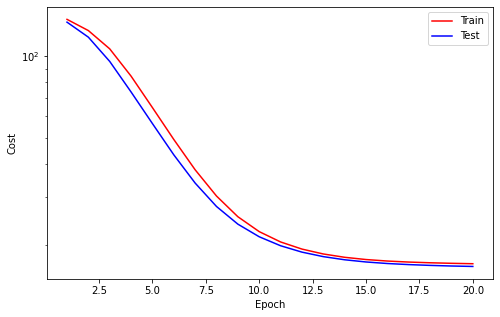

Test: 100%|██████████| 3/3 [00:00<00:00, 18.38it/s]



Epoch    21
Train_cost  = 17.0159 | Test_cost  = 16.6183 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 20.83it/s]



Epoch    22
Train_cost  = 16.9744 | Test_cost  = 16.5719 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 22.13it/s]



Epoch    23
Train_cost  = 16.9290 | Test_cost  = 16.5225 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 30.79it/s]



Epoch    24
Train_cost  = 16.8790 | Test_cost  = 16.4750 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 21.67it/s]



Epoch    25
Train_cost  = 16.8283 | Test_cost  = 16.4250 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 16.46it/s]



Epoch    26
Train_cost  = 16.7673 | Test_cost  = 16.3588 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 20.53it/s]



Epoch    27
Train_cost  = 16.6813 | Test_cost  = 16.2726 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 20.32it/s]



Epoch    28
Train_cost  = 16.5736 | Test_cost  = 16.1733 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 29.19it/s]



Epoch    29
Train_cost  = 16.4246 | Test_cost  = 16.0266 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 24.94it/s]



Epoch    30
Train_cost  = 16.2104 | Test_cost  = 15.8265 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 16.43it/s]



Epoch    31
Train_cost  = 15.9138 | Test_cost  = 15.5369 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 15.24it/s]



Epoch    32
Train_cost  = 15.5101 | Test_cost  = 15.1649 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 19.35it/s]



Epoch    33
Train_cost  = 15.0025 | Test_cost  = 14.5591 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 19.18it/s]



Epoch    34
Train_cost  = 14.1727 | Test_cost  = 13.7045 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 50.30it/s]



Epoch    35
Train_cost  = 13.2164 | Test_cost  = 12.5926 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 45.19it/s]



Epoch    36
Train_cost  = 11.9822 | Test_cost  = 11.5916 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 45.89it/s]



Epoch    37
Train_cost  = 10.9796 | Test_cost  = 10.6303 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 47.75it/s]



Epoch    38
Train_cost  = 10.0101 | Test_cost  = 9.8311 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 48.01it/s]



Epoch    39
Train_cost  = 9.2481 | Test_cost  = 9.1627 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 44.57it/s]



Epoch    40
Train_cost  = 8.6329 | Test_cost  = 8.5687 | 


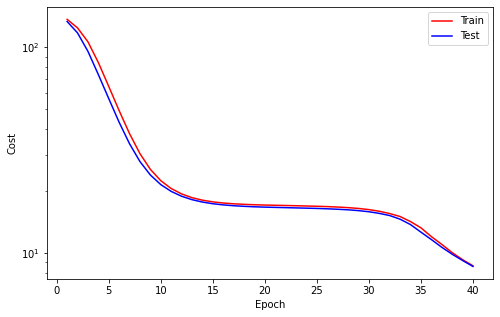

Test: 100%|██████████| 3/3 [00:00<00:00, 42.44it/s]



Epoch    41
Train_cost  = 8.1048 | Test_cost  = 8.0543 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 45.50it/s]



Epoch    42
Train_cost  = 7.6633 | Test_cost  = 7.6272 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 44.84it/s]



Epoch    43
Train_cost  = 7.2820 | Test_cost  = 7.2640 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 50.21it/s]



Epoch    44
Train_cost  = 6.9447 | Test_cost  = 6.9281 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 46.64it/s]



Epoch    45
Train_cost  = 6.6341 | Test_cost  = 6.6367 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 48.65it/s]



Epoch    46
Train_cost  = 6.3583 | Test_cost  = 6.3782 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 47.69it/s]



Epoch    47
Train_cost  = 6.1135 | Test_cost  = 6.1415 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 49.69it/s]



Epoch    48
Train_cost  = 5.8869 | Test_cost  = 5.9213 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 46.37it/s]



Epoch    49
Train_cost  = 5.6769 | Test_cost  = 5.7144 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 43.65it/s]



Epoch    50
Train_cost  = 5.4781 | Test_cost  = 5.5181 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 44.50it/s]



Epoch    51
Train_cost  = 5.2885 | Test_cost  = 5.3306 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 48.30it/s]



Epoch    52
Train_cost  = 5.1058 | Test_cost  = 5.1511 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 47.10it/s]



Epoch    53
Train_cost  = 4.9296 | Test_cost  = 4.9788 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 47.69it/s]



Epoch    54
Train_cost  = 4.7608 | Test_cost  = 4.8132 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 50.95it/s]



Epoch    55
Train_cost  = 4.5998 | Test_cost  = 4.6544 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 48.43it/s]



Epoch    56
Train_cost  = 4.4480 | Test_cost  = 4.5031 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 45.16it/s]



Epoch    57
Train_cost  = 4.3075 | Test_cost  = 4.3604 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 50.17it/s]



Epoch    58
Train_cost  = 4.1754 | Test_cost  = 4.2252 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 40.67it/s]



Epoch    59
Train_cost  = 4.0509 | Test_cost  = 4.0977 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 48.91it/s]



Epoch    60
Train_cost  = 3.9349 | Test_cost  = 3.9767 | 


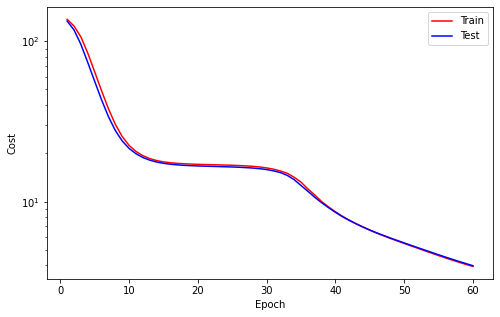

Test: 100%|██████████| 3/3 [00:00<00:00, 40.07it/s]



Epoch    61
Train_cost  = 3.8260 | Test_cost  = 3.8609 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 48.87it/s]



Epoch    62
Train_cost  = 3.7229 | Test_cost  = 3.7495 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 44.82it/s]



Epoch    63
Train_cost  = 3.6244 | Test_cost  = 3.6421 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 45.34it/s]



Epoch    64
Train_cost  = 3.5310 | Test_cost  = 3.5404 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 47.24it/s]



Epoch    65
Train_cost  = 3.4428 | Test_cost  = 3.4444 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 47.86it/s]



Epoch    66
Train_cost  = 3.3579 | Test_cost  = 3.3527 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 50.15it/s]



Epoch    67
Train_cost  = 3.2756 | Test_cost  = 3.2640 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 49.38it/s]



Epoch    68
Train_cost  = 3.1950 | Test_cost  = 3.1766 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 45.74it/s]



Epoch    69
Train_cost  = 3.1153 | Test_cost  = 3.0903 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 44.42it/s]



Epoch    70
Train_cost  = 3.0363 | Test_cost  = 3.0055 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 42.52it/s]



Epoch    71
Train_cost  = 2.9579 | Test_cost  = 2.9219 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 52.88it/s]



Epoch    72
Train_cost  = 2.8797 | Test_cost  = 2.8387 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 50.13it/s]



Epoch    73
Train_cost  = 2.8014 | Test_cost  = 2.7552 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 45.48it/s]



Epoch    74
Train_cost  = 2.7232 | Test_cost  = 2.6712 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 49.58it/s]



Epoch    75
Train_cost  = 2.6449 | Test_cost  = 2.5877 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 45.38it/s]



Epoch    76
Train_cost  = 2.5666 | Test_cost  = 2.5057 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 42.29it/s]



Epoch    77
Train_cost  = 2.4890 | Test_cost  = 2.4257 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 45.79it/s]



Epoch    78
Train_cost  = 2.4125 | Test_cost  = 2.3477 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 46.93it/s]



Epoch    79
Train_cost  = 2.3374 | Test_cost  = 2.2735 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 44.21it/s]



Epoch    80
Train_cost  = 2.2641 | Test_cost  = 2.2029 | 


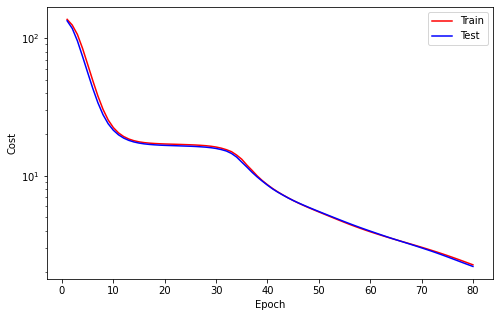

Test: 100%|██████████| 3/3 [00:00<00:00, 44.29it/s]



Epoch    81
Train_cost  = 2.1922 | Test_cost  = 2.1351 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 42.64it/s]



Epoch    82
Train_cost  = 2.1221 | Test_cost  = 2.0683 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 51.23it/s]



Epoch    83
Train_cost  = 2.0540 | Test_cost  = 2.0012 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 46.43it/s]



Epoch    84
Train_cost  = 1.9880 | Test_cost  = 1.9320 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 37.49it/s]



Epoch    85
Train_cost  = 1.9245 | Test_cost  = 1.8591 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 48.19it/s]



Epoch    86
Train_cost  = 1.8631 | Test_cost  = 1.7806 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 46.30it/s]



Epoch    87
Train_cost  = 1.8028 | Test_cost  = 1.6958 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 47.33it/s]



Epoch    88
Train_cost  = 1.7422 | Test_cost  = 1.6084 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 46.03it/s]



Epoch    89
Train_cost  = 1.6809 | Test_cost  = 1.5307 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 51.17it/s]



Epoch    90
Train_cost  = 1.6209 | Test_cost  = 1.4783 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 42.17it/s]



Epoch    91
Train_cost  = 1.5652 | Test_cost  = 1.4423 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 42.93it/s]



Epoch    92
Train_cost  = 1.5104 | Test_cost  = 1.3927 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 47.10it/s]



Epoch    93
Train_cost  = 1.4490 | Test_cost  = 1.3376 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 48.38it/s]



Epoch    94
Train_cost  = 1.3942 | Test_cost  = 1.2863 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 45.86it/s]



Epoch    95
Train_cost  = 1.3499 | Test_cost  = 1.2449 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 46.36it/s]



Epoch    96
Train_cost  = 1.3109 | Test_cost  = 1.2092 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 41.12it/s]



Epoch    97
Train_cost  = 1.2756 | Test_cost  = 1.1770 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 46.66it/s]



Epoch    98
Train_cost  = 1.2452 | Test_cost  = 1.1468 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 41.51it/s]



Epoch    99
Train_cost  = 1.2185 | Test_cost  = 1.1194 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 46.98it/s]



Epoch   100
Train_cost  = 1.1935 | Test_cost  = 1.0941 | 


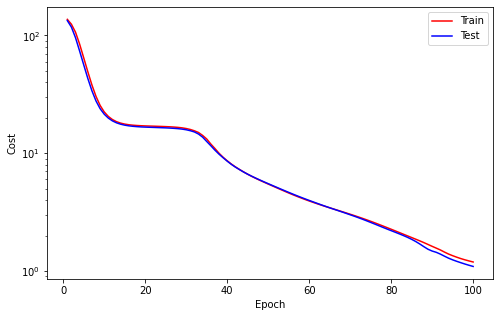

Test: 100%|██████████| 3/3 [00:00<00:00, 40.99it/s]



Epoch   101
Train_cost  = 1.1693 | Test_cost  = 1.0706 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 40.10it/s]



Epoch   102
Train_cost  = 1.1462 | Test_cost  = 1.0487 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 48.89it/s]



Epoch   103
Train_cost  = 1.1244 | Test_cost  = 1.0280 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 43.12it/s]



Epoch   104
Train_cost  = 1.1037 | Test_cost  = 1.0082 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 46.44it/s]



Epoch   105
Train_cost  = 1.0840 | Test_cost  = 0.9895 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 47.63it/s]



Epoch   106
Train_cost  = 1.0652 | Test_cost  = 0.9717 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 49.27it/s]



Epoch   107
Train_cost  = 1.0472 | Test_cost  = 0.9546 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 45.58it/s]



Epoch   108
Train_cost  = 1.0300 | Test_cost  = 0.9382 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 43.59it/s]



Epoch   109
Train_cost  = 1.0136 | Test_cost  = 0.9225 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 42.65it/s]



Epoch   110
Train_cost  = 0.9979 | Test_cost  = 0.9076 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 39.65it/s]



Epoch   111
Train_cost  = 0.9829 | Test_cost  = 0.8934 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 40.85it/s]



Epoch   112
Train_cost  = 0.9685 | Test_cost  = 0.8799 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 43.08it/s]



Epoch   113
Train_cost  = 0.9546 | Test_cost  = 0.8670 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 47.25it/s]



Epoch   114
Train_cost  = 0.9413 | Test_cost  = 0.8546 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 45.09it/s]



Epoch   115
Train_cost  = 0.9285 | Test_cost  = 0.8427 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 45.56it/s]



Epoch   116
Train_cost  = 0.9162 | Test_cost  = 0.8314 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 42.43it/s]



Epoch   117
Train_cost  = 0.9043 | Test_cost  = 0.8204 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 46.18it/s]



Epoch   118
Train_cost  = 0.8928 | Test_cost  = 0.8098 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 45.60it/s]



Epoch   119
Train_cost  = 0.8816 | Test_cost  = 0.7996 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 41.32it/s]



Epoch   120
Train_cost  = 0.8709 | Test_cost  = 0.7898 | 


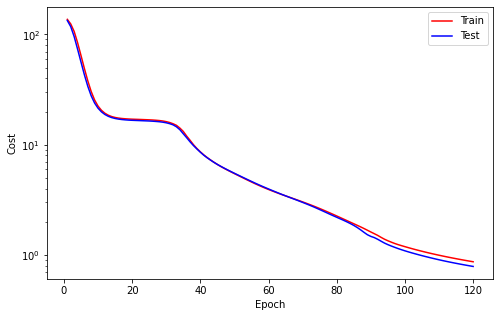

Test: 100%|██████████| 3/3 [00:00<00:00, 42.98it/s]



Epoch   121
Train_cost  = 0.8605 | Test_cost  = 0.7802 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 49.09it/s]



Epoch   122
Train_cost  = 0.8504 | Test_cost  = 0.7710 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 49.63it/s]



Epoch   123
Train_cost  = 0.8405 | Test_cost  = 0.7620 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 40.47it/s]



Epoch   124
Train_cost  = 0.8310 | Test_cost  = 0.7533 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 40.64it/s]



Epoch   125
Train_cost  = 0.8218 | Test_cost  = 0.7447 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 44.72it/s]



Epoch   126
Train_cost  = 0.8128 | Test_cost  = 0.7364 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 50.40it/s]



Epoch   127
Train_cost  = 0.8041 | Test_cost  = 0.7284 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 38.17it/s]



Epoch   128
Train_cost  = 0.7956 | Test_cost  = 0.7205 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 38.50it/s]



Epoch   129
Train_cost  = 0.7874 | Test_cost  = 0.7129 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 42.88it/s]



Epoch   130
Train_cost  = 0.7794 | Test_cost  = 0.7055 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 49.94it/s]



Epoch   131
Train_cost  = 0.7717 | Test_cost  = 0.6984 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 45.77it/s]



Epoch   132
Train_cost  = 0.7641 | Test_cost  = 0.6915 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 45.09it/s]



Epoch   133
Train_cost  = 0.7568 | Test_cost  = 0.6849 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 45.78it/s]



Epoch   134
Train_cost  = 0.7496 | Test_cost  = 0.6785 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 45.84it/s]



Epoch   135
Train_cost  = 0.7425 | Test_cost  = 0.6723 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 50.10it/s]



Epoch   136
Train_cost  = 0.7357 | Test_cost  = 0.6663 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 45.20it/s]



Epoch   137
Train_cost  = 0.7289 | Test_cost  = 0.6606 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 39.73it/s]



Epoch   138
Train_cost  = 0.7223 | Test_cost  = 0.6551 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 43.31it/s]



Epoch   139
Train_cost  = 0.7159 | Test_cost  = 0.6497 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 40.40it/s]



Epoch   140
Train_cost  = 0.7095 | Test_cost  = 0.6446 | 


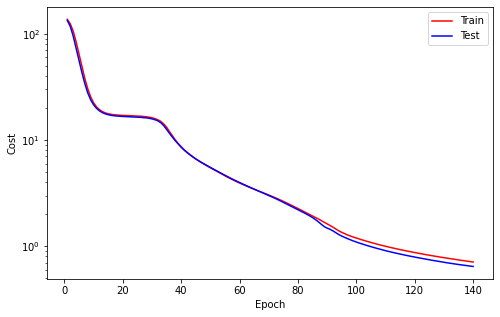

Test: 100%|██████████| 3/3 [00:00<00:00, 47.72it/s]



Epoch   141
Train_cost  = 0.7033 | Test_cost  = 0.6396 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 50.02it/s]



Epoch   142
Train_cost  = 0.6972 | Test_cost  = 0.6349 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 46.43it/s]



Epoch   143
Train_cost  = 0.6913 | Test_cost  = 0.6303 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 38.75it/s]



Epoch   144
Train_cost  = 0.6854 | Test_cost  = 0.6259 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 47.23it/s]



Epoch   145
Train_cost  = 0.6797 | Test_cost  = 0.6216 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 48.04it/s]



Epoch   146
Train_cost  = 0.6741 | Test_cost  = 0.6175 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 47.68it/s]



Epoch   147
Train_cost  = 0.6686 | Test_cost  = 0.6135 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 45.88it/s]



Epoch   148
Train_cost  = 0.6632 | Test_cost  = 0.6097 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 44.03it/s]



Epoch   149
Train_cost  = 0.6579 | Test_cost  = 0.6060 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 38.78it/s]



Epoch   150
Train_cost  = 0.6528 | Test_cost  = 0.6024 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 46.39it/s]



Epoch   151
Train_cost  = 0.6477 | Test_cost  = 0.5989 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 42.89it/s]



Epoch   152
Train_cost  = 0.6428 | Test_cost  = 0.5955 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 36.75it/s]



Epoch   153
Train_cost  = 0.6379 | Test_cost  = 0.5923 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 40.65it/s]



Epoch   154
Train_cost  = 0.6332 | Test_cost  = 0.5892 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 41.15it/s]



Epoch   155
Train_cost  = 0.6286 | Test_cost  = 0.5861 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 42.32it/s]



Epoch   156
Train_cost  = 0.6241 | Test_cost  = 0.5832 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 38.68it/s]



Epoch   157
Train_cost  = 0.6196 | Test_cost  = 0.5803 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 45.23it/s]



Epoch   158
Train_cost  = 0.6153 | Test_cost  = 0.5775 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 43.48it/s]



Epoch   159
Train_cost  = 0.6111 | Test_cost  = 0.5748 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 41.72it/s]



Epoch   160
Train_cost  = 0.6069 | Test_cost  = 0.5722 | 


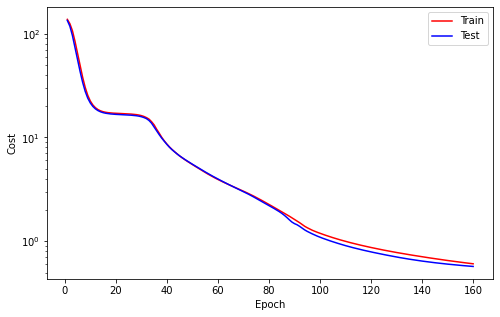

Test: 100%|██████████| 3/3 [00:00<00:00, 39.42it/s]



Epoch   161
Train_cost  = 0.6028 | Test_cost  = 0.5697 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 43.28it/s]



Epoch   162
Train_cost  = 0.5988 | Test_cost  = 0.5672 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 42.86it/s]



Epoch   163
Train_cost  = 0.5949 | Test_cost  = 0.5649 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 46.27it/s]



Epoch   164
Train_cost  = 0.5911 | Test_cost  = 0.5626 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 45.45it/s]



Epoch   165
Train_cost  = 0.5873 | Test_cost  = 0.5603 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 45.82it/s]



Epoch   166
Train_cost  = 0.5836 | Test_cost  = 0.5582 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 35.28it/s]



Epoch   167
Train_cost  = 0.5800 | Test_cost  = 0.5561 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 47.46it/s]



Epoch   168
Train_cost  = 0.5764 | Test_cost  = 0.5541 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 42.30it/s]



Epoch   169
Train_cost  = 0.5729 | Test_cost  = 0.5521 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 40.02it/s]



Epoch   170
Train_cost  = 0.5695 | Test_cost  = 0.5502 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 43.58it/s]



Epoch   171
Train_cost  = 0.5661 | Test_cost  = 0.5484 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 45.14it/s]



Epoch   172
Train_cost  = 0.5628 | Test_cost  = 0.5466 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 42.74it/s]



Epoch   173
Train_cost  = 0.5595 | Test_cost  = 0.5449 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 39.42it/s]



Epoch   174
Train_cost  = 0.5563 | Test_cost  = 0.5432 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 44.76it/s]



Epoch   175
Train_cost  = 0.5531 | Test_cost  = 0.5416 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 35.12it/s]



Epoch   176
Train_cost  = 0.5500 | Test_cost  = 0.5400 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 42.76it/s]



Epoch   177
Train_cost  = 0.5469 | Test_cost  = 0.5385 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 38.26it/s]



Epoch   178
Train_cost  = 0.5439 | Test_cost  = 0.5371 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 44.66it/s]



Epoch   179
Train_cost  = 0.5409 | Test_cost  = 0.5357 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 43.24it/s]



Epoch   180
Train_cost  = 0.5380 | Test_cost  = 0.5343 | 


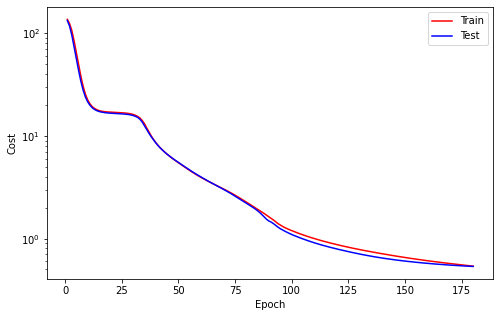

Test: 100%|██████████| 3/3 [00:00<00:00, 37.60it/s]



Epoch   181
Train_cost  = 0.5351 | Test_cost  = 0.5330 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 44.26it/s]



Epoch   182
Train_cost  = 0.5322 | Test_cost  = 0.5317 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 45.72it/s]



Epoch   183
Train_cost  = 0.5294 | Test_cost  = 0.5305 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 43.98it/s]



Epoch   184
Train_cost  = 0.5266 | Test_cost  = 0.5293 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 45.03it/s]



Epoch   185
Train_cost  = 0.5238 | Test_cost  = 0.5281 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 40.91it/s]



Epoch   186
Train_cost  = 0.5211 | Test_cost  = 0.5271 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 41.72it/s]



Epoch   187
Train_cost  = 0.5184 | Test_cost  = 0.5260 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 34.72it/s]



Epoch   188
Train_cost  = 0.5158 | Test_cost  = 0.5250 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 44.55it/s]



Epoch   189
Train_cost  = 0.5132 | Test_cost  = 0.5240 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 42.91it/s]



Epoch   190
Train_cost  = 0.5106 | Test_cost  = 0.5231 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 44.30it/s]



Epoch   191
Train_cost  = 0.5080 | Test_cost  = 0.5222 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 38.97it/s]



Epoch   192
Train_cost  = 0.5055 | Test_cost  = 0.5214 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 42.62it/s]



Epoch   193
Train_cost  = 0.5030 | Test_cost  = 0.5206 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 43.64it/s]



Epoch   194
Train_cost  = 0.5005 | Test_cost  = 0.5199 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 36.16it/s]



Epoch   195
Train_cost  = 0.4981 | Test_cost  = 0.5192 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 37.46it/s]



Epoch   196
Train_cost  = 0.4957 | Test_cost  = 0.5185 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 40.07it/s]



Epoch   197
Train_cost  = 0.4933 | Test_cost  = 0.5179 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 41.49it/s]



Epoch   198
Train_cost  = 0.4909 | Test_cost  = 0.5174 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 42.09it/s]



Epoch   199
Train_cost  = 0.4886 | Test_cost  = 0.5169 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 40.35it/s]



Epoch   200
Train_cost  = 0.4863 | Test_cost  = 0.5165 | 


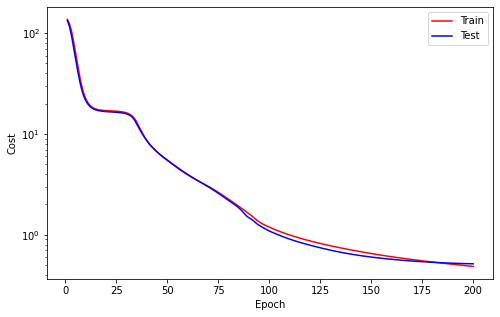

Test: 100%|██████████| 3/3 [00:00<00:00, 38.51it/s]



Epoch   201
Train_cost  = 0.4840 | Test_cost  = 0.5161 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 37.76it/s]



Epoch   202
Train_cost  = 0.4817 | Test_cost  = 0.5158 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 40.83it/s]



Epoch   203
Train_cost  = 0.4795 | Test_cost  = 0.5156 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 37.59it/s]



Epoch   204
Train_cost  = 0.4773 | Test_cost  = 0.5154 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 47.07it/s]



Epoch   205
Train_cost  = 0.4751 | Test_cost  = 0.5154 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 38.96it/s]



Epoch   206
Train_cost  = 0.4730 | Test_cost  = 0.5154 | 
==> EarlyStop patience =  1 | Best test_cost: 0.5154


Test: 100%|██████████| 3/3 [00:00<00:00, 40.57it/s]



Epoch   207
Train_cost  = 0.4709 | Test_cost  = 0.5156 | 
==> EarlyStop patience =  2 | Best test_cost: 0.5154


Test: 100%|██████████| 3/3 [00:00<00:00, 41.33it/s]



Epoch   208
Train_cost  = 0.4688 | Test_cost  = 0.5160 | 
==> EarlyStop patience =  3 | Best test_cost: 0.5154


Test: 100%|██████████| 3/3 [00:00<00:00, 45.94it/s]



Epoch   209
Train_cost  = 0.4668 | Test_cost  = 0.5166 | 
==> EarlyStop patience =  4 | Best test_cost: 0.5154


Test: 100%|██████████| 3/3 [00:00<00:00, 40.84it/s]



Epoch   210
Train_cost  = 0.4648 | Test_cost  = 0.5175 | 
==> EarlyStop patience =  5 | Best test_cost: 0.5154
==> Execute Early Stopping at epoch: 210 | Best test_cost: 0.5154
==> Best model is saved at /content/data/model/bilstm


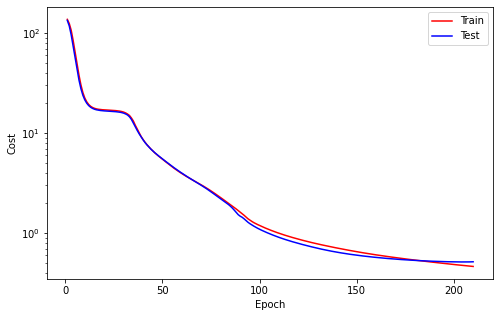

In [15]:
while True:
  train_cost = loop_fn("train", train_set, train_loader, model, criterion, optimizer, device)
  with torch.no_grad():
    test_cost= loop_fn("test", test_set, test_loader, model, criterion, optimizer, device)

  #Logging
  callback.log(train_cost, test_cost)

  #Checkpoint
  callback.save_checkpoint()

  #Runtime_plotting
  callback.cost_runtime_plotting()

  #Early stopping
  if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break

## Sanity Check

In [16]:
# utils
def data4pred(model, dataset, dataloader, device):    
    preds, targets = [], []
    hidden = None
    with torch.no_grad():
        model.eval()
        for inputs, target in dataloader:
            inputs = inputs.to(device)
            
            output, hidden = model(inputs, hidden)
            preds += output.flatten().tolist()
            targets += target.flatten().tolist()

    plt.plot(dataset.target_ticks, targets, 'b-', label="data")
    plt.plot(dataset.target_ticks, preds, 'r-', label="pred")
    plt.legend()    
    
def pred4pred(model, dataset, dataloader, device, n_prior=500, n_forecast=200):
    preds, targets = [], []
    hidden = None    
    end = n_prior + n_forecast    
    with torch.no_grad():
        model.eval()       
        for idx, (inputs, target) in enumerate(dataloader):
            if idx == end:
                break
            elif idx > n_prior:
                inputs[0, 0, 0] = preds[-1]
                
            inputs = inputs.to(device)
            output, hidden = model(inputs, hidden)
            
            if idx > n_prior:
                preds.append(output.flatten().tolist()[-1])
            else:
                preds += output.flatten().tolist()   
            targets += target.flatten().tolist()

    plt.plot(dataset.target_ticks[:n_prior], targets[:n_prior], 'b-', label="history_data")
    plt.plot(dataset.target_ticks[n_prior:end], targets[n_prior:], 'b-', label="unseen_data", alpha=0.3)
    plt.plot(dataset.target_ticks[:end], preds, 'r-', label="prediction")
    plt.axvline(dataset.target_ticks[n_prior], color='k', linestyle="--", linewidth=1)
    plt.legend()   

In [17]:
train_forecast_set = TimeSeriesDataset(ts_train, "Temp", 1)
trainforecastloader = DataLoader(train_forecast_set)
test_forecast_set = TimeSeriesDataset(ts_test, "Temp", 1)
testforecastloader = DataLoader(test_forecast_set)

(N, S, F): (2736, 1, 1)
Note: last 0 data excluded

(N, S, F): (912, 1, 1)
Note: last 0 data excluded



Text(0.5, 1.0, 'Test')

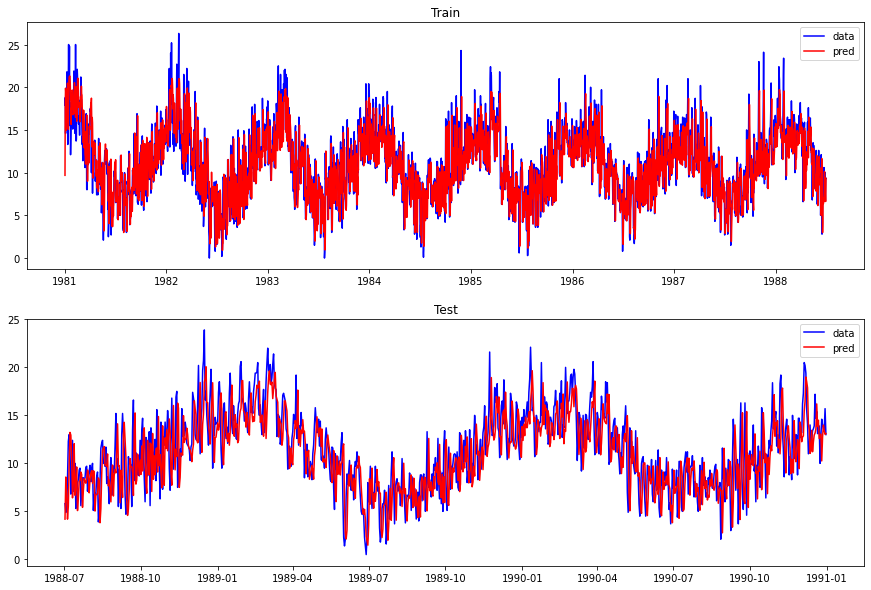

In [18]:
# Data 4 Pred
plt.figure(figsize=(15, 10))

plt.subplot(211)
data4pred(model, train_forecast_set, trainforecastloader, device)
plt.title("Train")

plt.subplot(212)
data4pred(model, test_forecast_set, testforecastloader, device)
plt.title("Test")

Text(0.5, 1.0, 'test')

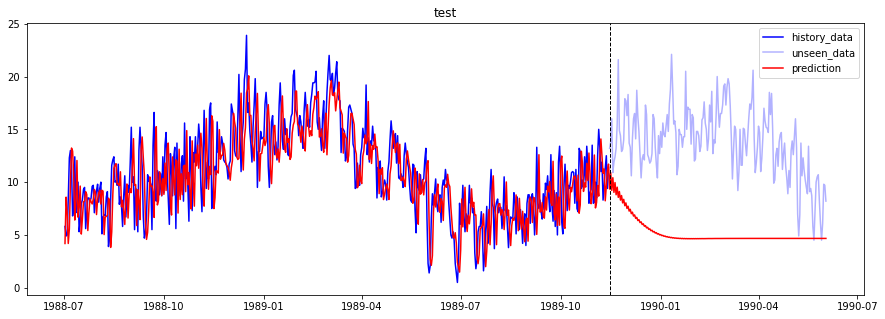

In [19]:
# Pred 4 Pred
plt.figure(figsize=(15, 5))
pred4pred(model, test_forecast_set, testforecastloader, device)
plt.title("test")